# Modelling and Evaluation

## Objectives

- Complete model to predict if a cherry leaf is infected with powdery mildew.

## Inputs

- inputs/cherry_leaves_raw_dataset/cherry-leaves/train
- inputs/cherry_leaves_raw_dataset/cherry-leaves/validation
- inputs/cherry_leaves_raw_dataset/cherry-leaves/test
Each folder has 2 subfolders: 'healthy' and 'powdery_mildew'
- image_shape pkl [pickle] file


## Outputs

- Image distribution plot, train vs validation vs test.
- Machine learning model creation and training.
- Plotting model performance.
- Prediction of a selected image file.

## Install dependencies

In [35]:
pip install -r /workspace/mildew-detection/requirements.txt

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread


## Change working directory

Change working directory from current to parent folder.

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

In [4]:
os.chdir("/workspace/mildew-detection")
print("You set a new current directory.")

You set a new current directory.


In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

## Set input directories

In [6]:
data_dir = "inputs/cherry_leaves_raw_dataset/cherry-leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

## Set output directories

In [7]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory already exists, please create a new version if required.")
else:
    os.makedirs(name=file_path)

This directory already exists, please create a new version if required.


## Set label names

In [8]:
labels = os.listdir(train_dir)
print("The image labels are ", labels)

The image labels are  ['healthy', 'powdery_mildew']


Set image shape

In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(80, 80, 3)

## Check number of images in the respective sets

Set size will be plotted and the image saved to outputs, pre-image pool augmentation

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


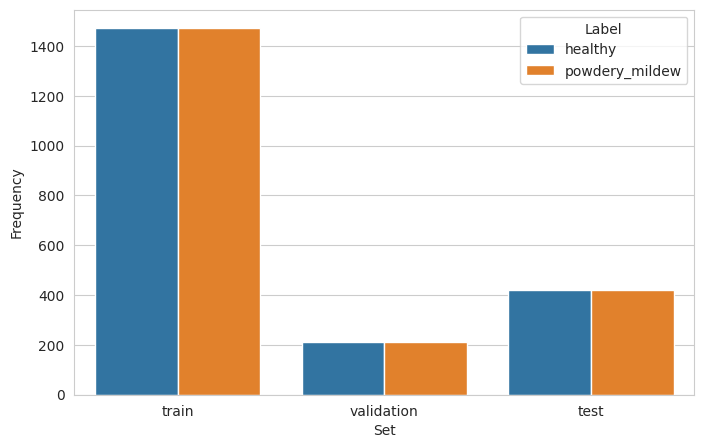

In [10]:
# A dataframe is initialised to store the data
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

folders = ['train', 'validation', 'test']

# Iterate through folders, labels, and count the images present
for folder in folders:
    for label in labels:
        folder_path = os.path.join(data_dir, folder, label)
        num_images = len(os.listdir(folder_path))
        df_freq = df_freq.append({'Set': folder, 'Label': label, 'Frequency': num_images}, ignore_index=True)
        print(f"* {folder} - {label}: {num_images} images")

# Plot label distribution
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/label_distrib_pre_augmentation.png', bbox_inches='tight', dpi=150)
plt.show()

## Display distribution: Pie chart

For simpler visualisation, a pie chart of image distribution is created and saved

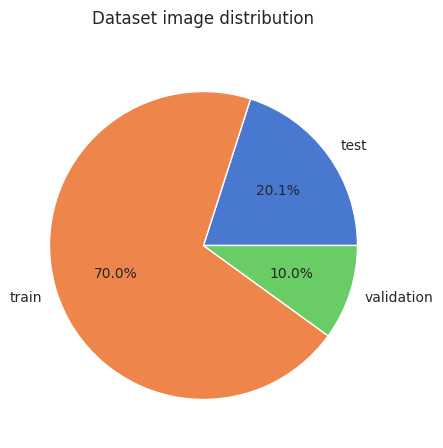

In [11]:
folders = os.listdir(data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(10,5))
colors = sns.color_palette('muted')[0:9]
plt.pie(data, labels = folders, colors = colors, autopct='%.1f%%')
plt.title(f'Dataset image distribution\n')
plt.savefig(f'{file_path}/image_distribution_pie.png', bbox_inches='tight', dpi=150)
plt.show()

It can be seen that they're split 70/10/20 to the nearest percent

## Image augmentation

The dataset will be augmented to increase the image pool, hopefully leading to greater accuracy

The ImageDataGenerator is imported and initialised

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

And the image pool for each set is augmented

### Train set

In [13]:
batch_size = 32
train_set = augmented_image_data.flow_from_directory(train_dir, # Take images from 'train' folder
                                                    target_size=image_shape[:2], 
                                                    color_mode='rgb',
                                                    batch_size=batch_size, 
                                                    class_mode='binary', 
                                                    shuffle=True # Shuffle the images
                                                    )
train_set.class_indices    

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Validation set

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Test set

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Save class_indices as a pkl file (do after i fix augmentation issue)

In [16]:
# joblib.dump(value=train_set.class_indices,
#             filename=f"{file_path}/class_indices.pkl")

((I want to re-plot with augmented images but they haven't been augmented.... still the same no. as before))

In [17]:
# # A dataframe is initialised to store the data
# df_freq_aug = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# folders = ['train', 'validation', 'test']

# # Iterate through folders, labels, and count the images present
# for folder in folders:
#     for label in labels:
#         folder_path = os.path.join(data_dir, folder, label)
#         num_images = len(os.listdir(folder_path))
#         df_freq_aug = df_freq.append({'Set': folder, 'Label': label, 'Frequency': num_images}, ignore_index=True)
#         print(f"* {folder} - {label}: {num_images} images")

# # Plot label distribution
# sns.set_style("whitegrid")
# plt.figure(figsize=(8,5))
# sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
# # plt.savefig(f'{file_path}/label_distrib_pre_augmentation.png', bbox_inches='tight', dpi=150)
# plt.show()

## Plot augmented images for each set (showing 3 sample images from each)

### Train set

(32, 80, 80, 3)


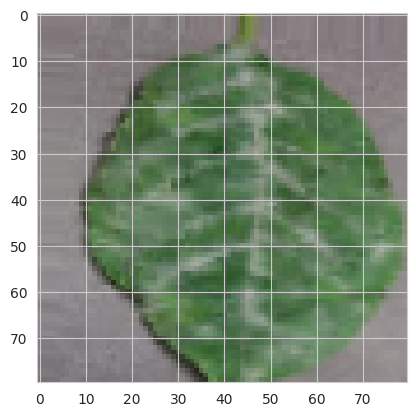

(32, 80, 80, 3)


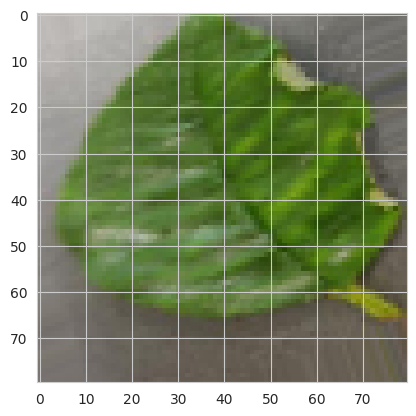

(32, 80, 80, 3)


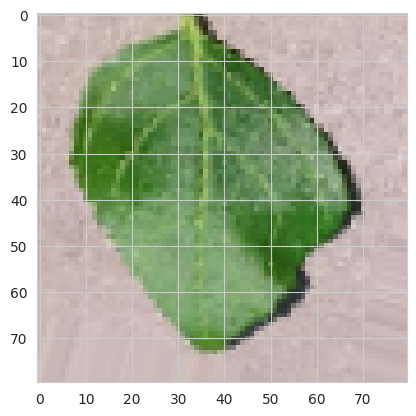

In [18]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Validation set

(32, 80, 80, 3)


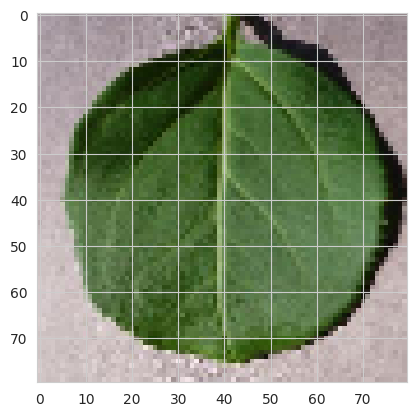

(32, 80, 80, 3)


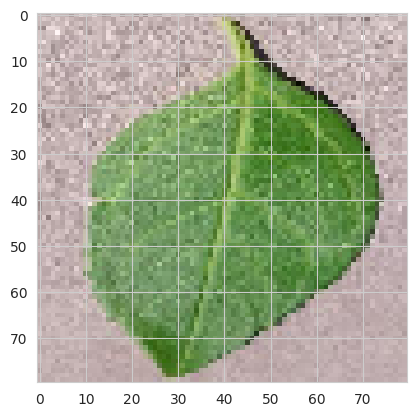

(32, 80, 80, 3)


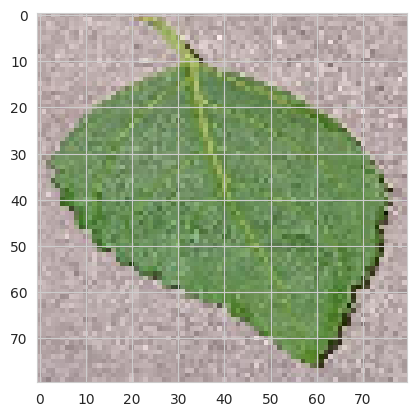

In [19]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Test set

(32, 80, 80, 3)


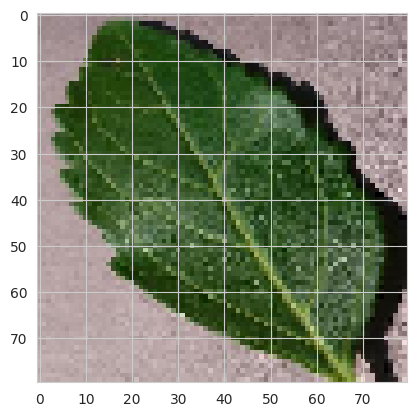

(32, 80, 80, 3)


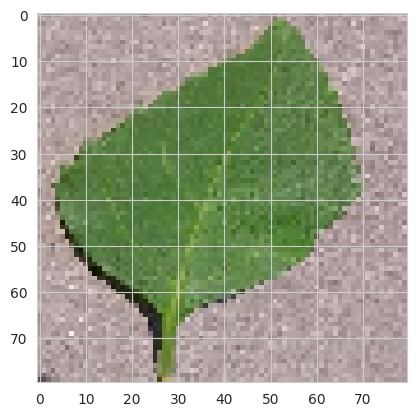

(32, 80, 80, 3)


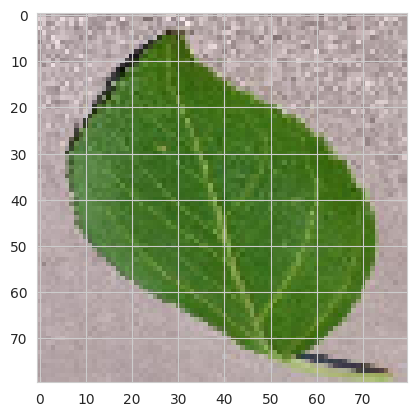

In [20]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

# Machine Learning Model Creation

Import model packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling3D

Create model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential()

    # input layer
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # convolution layers
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))

    # output
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='Nadam',
                metrics=['accuracy'])

    return model

Show a summary of the model

In [23]:
create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

2024-03-16 03:53:06.076660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Early stopping

Early stopping is included to stop the model once it starts to overfit

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for training

In [25]:
model = create_model()
model.fit(train_set, epochs=40, 
        steps_per_epoch=len(train_set.classes) // batch_size,
        validation_data=validation_set,
        callbacks=[early_stop],
        verbose=1
        )

Epoch 1/40


2024-03-16 03:53:06.307118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


92/92 [==============================] - 22s 222ms/step - loss: 0.4549 - accuracy: 0.7796 - val_loss: 0.1269 - val_accuracy: 0.9690
Epoch 2/40
92/92 [==============================] - 18s 192ms/step - loss: 0.1464 - accuracy: 0.9507 - val_loss: 0.0305 - val_accuracy: 0.9952
Epoch 3/40
92/92 [==============================] - 17s 189ms/step - loss: 0.0995 - accuracy: 0.9643 - val_loss: 0.0182 - val_accuracy: 0.9976
Epoch 4/40
92/92 [==============================] - 25s 269ms/step - loss: 0.0736 - accuracy: 0.9776 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 5/40
51/92 [===============>..............] - ETA: 7s - loss: 0.0342 - accuracy: 0.9920

KeyboardInterrupt: 

### Save the model

In [ ]:
model.save('outputs/v1/malaria_detector_model.h5')

# Model performance

## Model learning curve

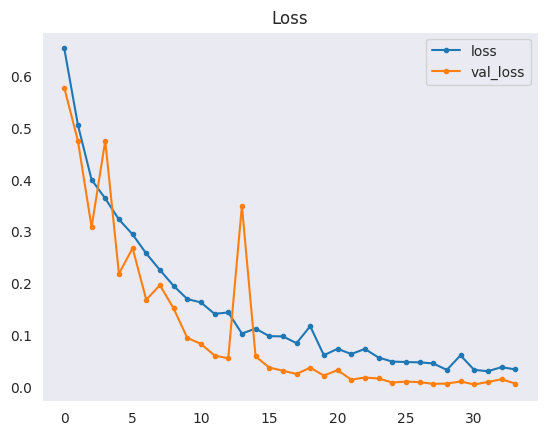

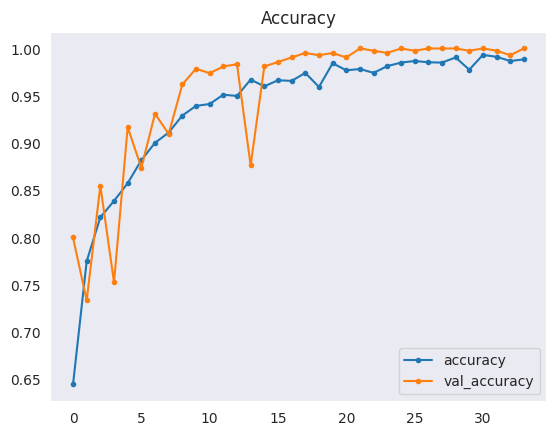

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("dark")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(
#     go.Scatter( y=model.history.history['val_loss'], name="val_loss"),
#     secondary_y=False,
# )
# fig.add_trace(
#     go.Scatter( y=model.history.history['loss'], name="loss"),
#     secondary_y=False,
# )
# fig.add_trace(
#     go.Scatter( y=model.history.history['val_accuracy'], name="val accuracy"),
#     secondary_y=True,
# )
# fig.add_trace(
#     go.Scatter( y=model.history.history['accuracy'], name="accuracy"),
#     secondary_y=True,
# )

# fig.update_layout(
#     title_text="Loss/Accuracy of LSTM Model"
# )

# fig.update_xaxes(title_text="Epoch")

# fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

# fig.update_layout(
#     autosize=False,
#     width=800, 
#     height=500, 
#     )

# fig.show()
# # fig.write_image(f'{file_path}/model_history.png')

KeyError: 'val_loss'

## Model evaluation

Load saved model

In [ ]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

Check and confirm model performance on test set

In [ ]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 2s 85ms/step - loss: 0.0249 - accuracy: 0.9929


In [ ]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: {:.4f}%".format(evaluation[0]))

 7/27 [======>.......................] - ETA: 0s - loss: 0.0377 - accuracy: 0.9955

27/27 [==============================] - 1s 41ms/step - loss: 0.0249 - accuracy: 0.9929
Model accuracy: 99.29%
Model Loss: 0.0249%


The model performs with over 99% accuracy, easily meeting the business requirement of 97%

Save evaluation pkl file

In [ ]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

An image from the 'healthy' label is fed into the model to randomly check accuracy

Image shape: (80, 80), Image mode: RGB


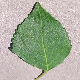

In [28]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # label '0' = 'healthy'

pil_image = image.load_img(test_dir + '/' + label + '/' + os.listdir(test_dir+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to an array for prediction

In [29]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


The prediction is run

In [30]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
prediction_class = target_map[prediction_probability > 0.5]

if prediction_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

0.9998790064710192
healthy


The steps above are repeated for a random infected image as a second check

Image shape: (80, 80), Image mode: RGB


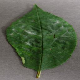

In [31]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # label '1' = 'powdery_mildew'

pil_image = image.load_img(test_dir + '/' + label + '/' + os.listdir(test_dir+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [32]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


In [33]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
prediction_class = target_map[prediction_probability > 0.5]

if prediction_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

0.99948645
powdery_mildew


# Conclusions

- A model was created and the parameters/hyperparameters tuned using different numbers of nodes, loss metrics, epochs and optimizers and emerged as extremely accurate (>99%)
- A larger dataset, as well as further tuning of hyperparameters may help to refine accuracy somewhat, though the model already performs well above the required 97%